# Moving self around
The agent got some *senses*: [background](VAE.ipynb) and [dynamics](ConvLSTM.ipynb).
For the next challenge we want some *self-awareness*: this time we want the agent to develop some reasonable expectation of what it would see after taking a specific action in a specific state.

Note: we used term *self-awareness* here to refer the composite model which requires an internal representation build and maintained, vs. *senses* which refer here the simple direct-mapping models.

In [1]:
import gym
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from gym_unity.envs import UnityEnv
from local import train_online, plot_history, run_seq
%matplotlib inline

Using TensorFlow backend.


In [2]:
env_name = None # use Unity editor with SimpleEnvironment scene active
#env_name = './Exec/Background' # use executable
env = UnityEnv(env_name, worker_id = 0, use_visual = True)

INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: SimpleEnvironment
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: Turn HORIZONTAL, Tilt VERTICAL
INFO:gym_unity:1 agents within environment.


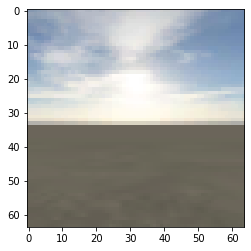

In [3]:
env.reset()
# get observation after taking action 0,0 (doing nothing)
observation, r, s, info = env.step([0.0, 0.0])

plt.imshow(observation)
plt.show()

In [4]:
IMG_DIM = observation.shape
ACT_DIM = (2,) # azimuth, altitude
N_CHANNELS = observation.shape[-1]
print('Image shape: {}  Flat size: {}  Channels: {}'\
      .format(IMG_DIM, np.prod(IMG_DIM), N_CHANNELS))

Image shape: (64, 64, 3)  Flat size: 12288  Channels: 3


## Autoencoder
For this exercise we are going to build a multi-layer convolutional neural network which predicts the next observation given the current observation and the action taken. We build a composite model: encoder, decoder, and mapper; and we train all three *online*.

In [5]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Dense, Flatten, Concatenate, Reshape
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU

In [6]:
# agent's brain capacity
LATENT_DIM = 8

# agent's moves
ACTION = {
    'Right':[1., 0.],
    'Left':[-1., 0.],
    'Up':[0., -1.],
    'Down':[0., 1.],
    'View':[0., 0.] }

In [7]:
# agent's cortex structure
N_FILTERS = 32
N_LAYERS = 3

In [8]:
# take an observation + action pair and output `idea`
def encoder(img_dim, act_dim, latent_dim, name = 'encoder'):
    n, f, s = N_LAYERS, N_FILTERS, (3, 3)
    observation = Input(shape = img_dim, name = 'observation')
    action = Input(shape = act_dim, name = 'action')
    thought = observation
    # hidden convolution layers
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        # normalization is important here
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = MaxPooling2D((2, 2), padding = 'same')(thought)
    thought = Flatten()(thought)
    thought = Concatenate()([thought, action])
    thought = Dense(latent_dim, activation = None, name = 'idea')(thought)
    idea = BatchNormalization()(thought)
    return Model([observation, action], idea, name = name)

In [9]:
# instantiate encoder model
encode = encoder(IMG_DIM, ACT_DIM, LATENT_DIM)
encode.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         observation[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [10]:
# take `idea` and restore the image in the original format
def decoder(img_dim, latent_dim, name = 'decoder'):
    n, f, s = N_LAYERS - 1, N_FILTERS, (5, 5)
    d = img_dim[0]//np.power(2, n)
    idea = Input(shape = (latent_dim,), name = 'idea')
    thought = Dense(d * d * f, activation = 'relu')(idea)
    thought = Reshape((d, d, f))(thought)
    for i in range(n):
        thought = Conv2D(f, s, activation = None, padding = 'same')(thought)
        thought = BatchNormalization()(thought)
        thought = LeakyReLU(alpha = .3)(thought)
        thought = UpSampling2D((2, 2))(thought)
    view = Conv2D(img_dim[-1], (3, 3), activation = 'sigmoid', padding = 'same', name = 'imagined')(thought)    
    return Model(idea, view, name = name)

In [11]:
# instantiate decoder model
decode = decoder(IMG_DIM, LATENT_DIM)
decode.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
idea (InputLayer)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              73728     
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
__________

In [12]:
# put it all together
def autoencoder(img_dim, act_dim, latent_dim):
    # encoder
    encode = encoder(img_dim, act_dim, latent_dim)
    encode.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # decoder
    decode = decoder(img_dim, latent_dim)
    decode.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # inputs
    observation = Input(shape = img_dim, name = 'observation')
    action = Input(shape = act_dim, name = 'action')
    # network
    mapper = Model([observation, action], decode(encode([observation, action])))
    mapper.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return encode, decode, mapper


encode, decode, model = autoencoder(IMG_DIM, ACT_DIM, LATENT_DIM)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
action (InputLayer)             (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            36216       observation[0][0]                
                                                                 action[0][0]                     
__________________________________________________________________________________________________
decoder (Model)                 (None, 64, 64, 3)    126115      encoder[1][0]                    
Total para

In [13]:
# return inputs, targets
def make_batch(V, A, X):
    # we've got V: observations resulted from actions A
    # we need observations A was initiated from
    # discard first pair and instead append pair:
    # zero-action (no move) and the last observation
    A1 = np.vstack((A[1:,:], np.zeros((1, 2))))
    V1 = np.vstack((V[1:,:], V[-1:,:]))
    return [V, A1], V1

      1 Loss  trainig: 0.0453 validation: 0.0697
     10 Loss  trainig: 0.0062 validation: 0.0179
     20 Loss  trainig: 0.0054 validation: 0.0060
     30 Loss  trainig: 0.0043 validation: 0.0047
     40 Loss  trainig: 0.0044 validation: 0.0043
     50 Loss  trainig: 0.0040 validation: 0.0039
     60 Loss  trainig: 0.0036 validation: 0.0045
     70 Loss  trainig: 0.0032 validation: 0.0038
     80 Loss  trainig: 0.0030 validation: 0.0034
     90 Loss  trainig: 0.0028 validation: 0.0043
    100 Loss  trainig: 0.0023 validation: 0.0034


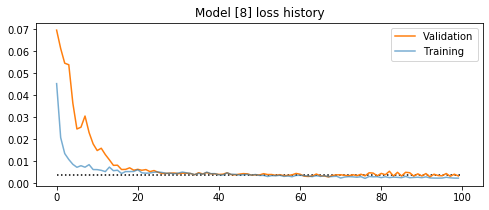

In [14]:
log, V, A, X = train_online(env, model, make_batch)
plot_history(log, 'Model [%d] loss history' % LATENT_DIM)

In [15]:
# compare visual observation and predicted view
def plot_predicted_vs_observed(views, actions, predictions, observations):
    k = len(views)
    fig, ax = plt.subplots(3, k, figsize = (15, 6))
    for i in range(k):
        ax[0][i].set_title('Current')
        ax[0][i].imshow(views[i])
        ax[1][i].imshow(predictions[i])
        ax[2][i].imshow(observations[i])
        for j,t in enumerate(['Move [%.0f, %.0f]' % tuple(actions[i]), 'Predicted', 'Observed']):
            ax[j][i].set_xlabel(t)
            ax[j][i].set_xticks([])
            ax[j][i].set_yticks([])
    plt.show()

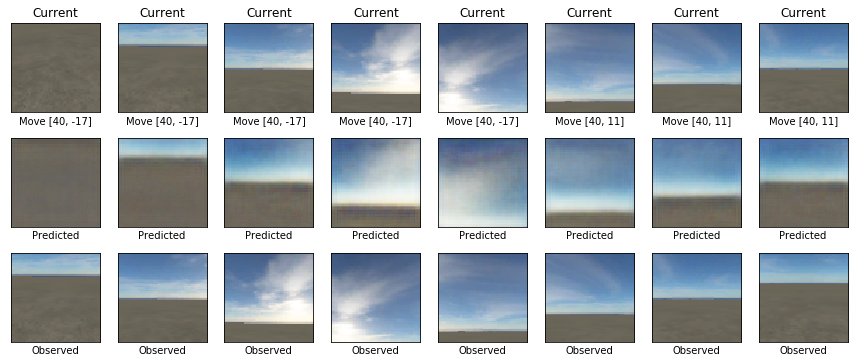

In [16]:
k = 9
env.reset()
_,__,___,____ = env.step([-180., 50.])
actions = [np.array([360./k, -150./k]) for i in range(k//2 + 1)] +\
          [np.array([360./k, 100./k]) for i in range(k//2)]
observations, coords = run_seq(env, actions, [-180., 50.])

actions = np.array(actions)[:-1,:]
views = np.array(observations)[:-1,:]
observations = np.array(observations)[1:,:]
predictions = model.predict([views, actions/360.])
plot_predicted_vs_observed(views, actions, predictions, observations)

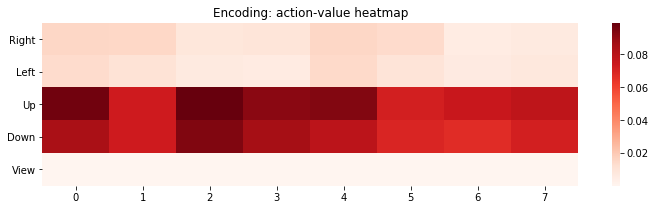

In [17]:
def encoding_heatmap(env, model, dim, cmap = 'Reds'):
    diff = np.zeros((5, dim))
    ampl = 10.
    env.reset()
    for i,action in enumerate(ACTION.values()):
        action = np.array(action)
        for _ in range(100):
            loc = [rnd.randint(-350, 350), rnd.randint(-50, 50)] 
            o1, _,__,___ = env.step(loc)
            e1 = model.predict([np.array([o1]), np.array([[0., 0.]])])
            o2, _,__,___ = env.step(action * ampl)
            e2 = model.predict([np.array([o2]), np.array([action])/360.])
            diff[i,:] += ((e1 - e2) ** 2).reshape(-1)
            e1 = e2
    fig, ax = plt.subplots(figsize = (12, 3))
    sb.heatmap(np.sqrt(diff)/100, ax = ax, yticklabels = list(ACTION.keys()), cmap = cmap)
    plt.title('Encoding: action-value heatmap')
    plt.yticks(rotation = 0)
    plt.show()
    
encoding_heatmap(env, encode, LATENT_DIM)    

No surprize here: most noticeable changes happen when moving up and down, left and right much less interesting, and view in general is quite obviously boring.

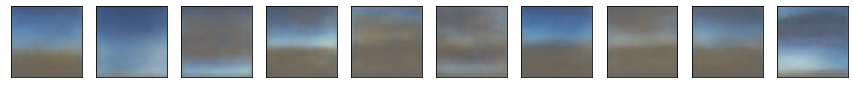

In [18]:
# decode random noise
def show_dreams(dreams):
    k = len(dreams)
    fig, ax = plt.subplots(1, k, figsize = (15, 6))
    for i in range(k):    
        ax[i].imshow(dreams[i,:])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()    

show_dreams(decode.predict(rnd.uniform(-1., 1., size = (10, LATENT_DIM))))

No surprize here either: agent dreams about *sky, ground, horizon and clouds*.

In [19]:
# save model
encode.save_weights('env-{}-encode.h5'.format(LATENT_DIM))
decode.save_weights('env-{}-decode.h5'.format(LATENT_DIM))
model.save_weights('env-{}-auto.h5'.format(LATENT_DIM))

Let's explore the effect of LATENT_DIM value.


Training latent dim 4 ...
      1 Loss  trainig: 0.0412 validation: 0.0634
     10 Loss  trainig: 0.0066 validation: 0.0182
     20 Loss  trainig: 0.0056 validation: 0.0077
     30 Loss  trainig: 0.0048 validation: 0.0062
     40 Loss  trainig: 0.0042 validation: 0.0052
     50 Loss  trainig: 0.0048 validation: 0.0050
     60 Loss  trainig: 0.0046 validation: 0.0052
     70 Loss  trainig: 0.0036 validation: 0.0045
     80 Loss  trainig: 0.0039 validation: 0.0042
     90 Loss  trainig: 0.0039 validation: 0.0045
    100 Loss  trainig: 0.0027 validation: 0.0031


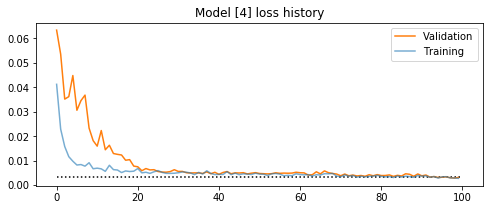

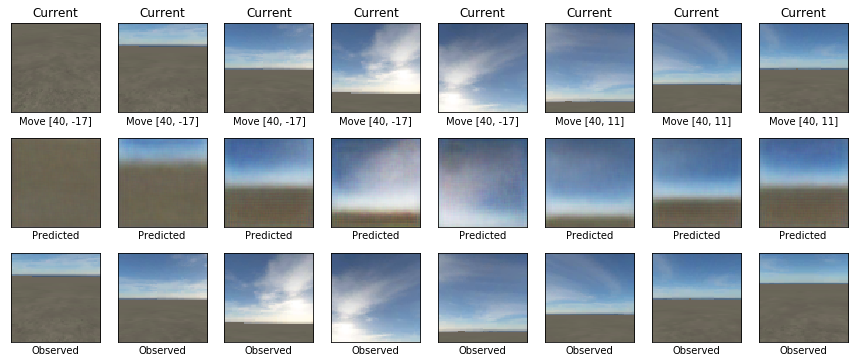

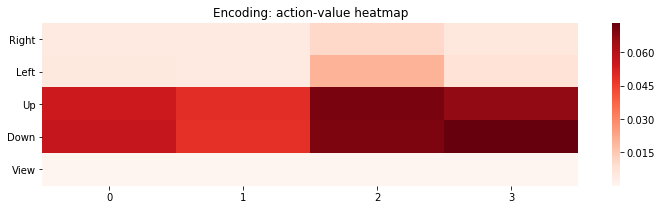

Dreams (decoded noise)


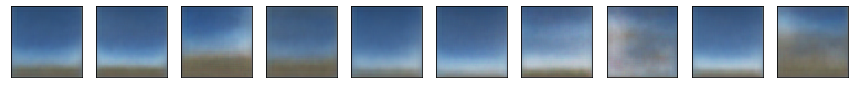


Training latent dim 16 ...
      1 Loss  trainig: 0.0430 validation: 0.0828
     10 Loss  trainig: 0.0055 validation: 0.0227
     20 Loss  trainig: 0.0051 validation: 0.0088
     30 Loss  trainig: 0.0042 validation: 0.0046
     40 Loss  trainig: 0.0038 validation: 0.0042
     50 Loss  trainig: 0.0034 validation: 0.0040
     60 Loss  trainig: 0.0035 validation: 0.0036
     70 Loss  trainig: 0.0026 validation: 0.0031
     80 Loss  trainig: 0.0024 validation: 0.0023
     90 Loss  trainig: 0.0024 validation: 0.0028
    100 Loss  trainig: 0.0019 validation: 0.0023


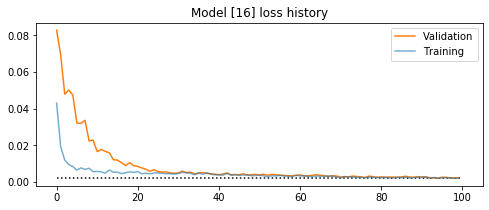

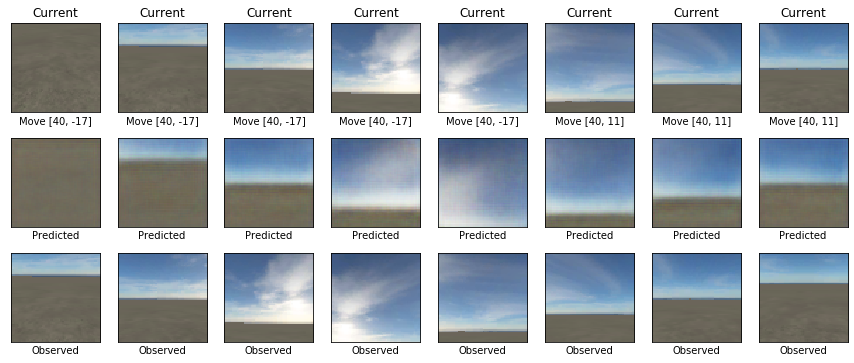

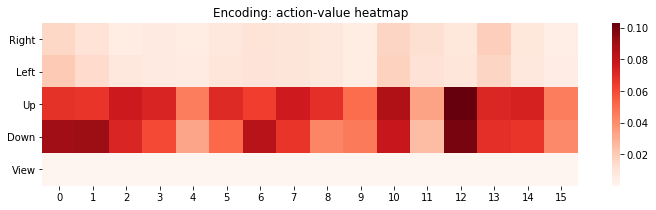

Dreams (decoded noise)


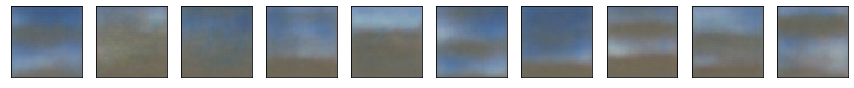


Training latent dim 32 ...
      1 Loss  trainig: 0.0405 validation: 0.0997
     10 Loss  trainig: 0.0052 validation: 0.0138
     20 Loss  trainig: 0.0048 validation: 0.0065
     30 Loss  trainig: 0.0039 validation: 0.0041
     40 Loss  trainig: 0.0037 validation: 0.0045
     50 Loss  trainig: 0.0031 validation: 0.0033
     60 Loss  trainig: 0.0033 validation: 0.0045
     70 Loss  trainig: 0.0022 validation: 0.0026
     80 Loss  trainig: 0.0023 validation: 0.0024
     90 Loss  trainig: 0.0025 validation: 0.0018
    100 Loss  trainig: 0.0018 validation: 0.0020


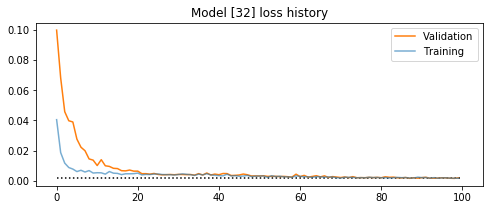

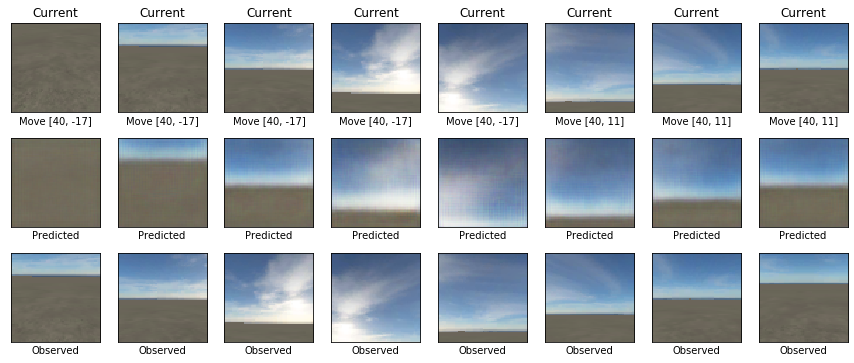

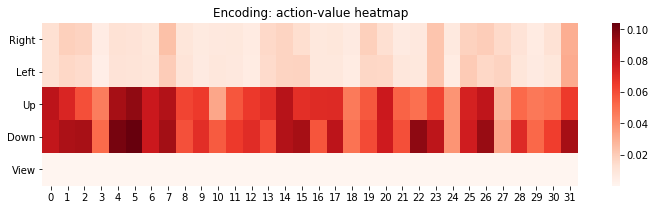

Dreams (decoded noise)


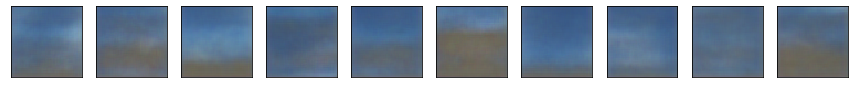

In [20]:
# check models with different latent dim
for LATENT_DIM in [4, 16, 32]:
    print('\nTraining latent dim {} ...'.format(LATENT_DIM))
    encode, decode, model = autoencoder(IMG_DIM, ACT_DIM, LATENT_DIM)
    log, V, A, X = train_online(env, model, make_batch)
    plot_history(log, 'Model [%d] loss history' % LATENT_DIM)
    predictions = model.predict([views, actions/360.])
    plot_predicted_vs_observed(views, actions, predictions, observations)
    encoding_heatmap(env, encode, LATENT_DIM)
    print('Dreams (decoded noise)')
    show_dreams(decode.predict(rnd.uniform(-1., 1., size = (10, LATENT_DIM))))
    encode.save_weights('env-{}-encode.h5'.format(LATENT_DIM))
    decode.save_weights('env-{}-decode.h5'.format(LATENT_DIM))
    model.save_weights('env-{}-auto.h5'.format(LATENT_DIM))

In [21]:
env.close()